# Food diversity in Bronx Area

In [1]:
!conda install -c conda-forge folium=0.5.0 --yes 
import folium 
import numpy as np 
import pandas as pd


Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py35_1 conda-forge
    branca:  0.3.1-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge

altair-2.2.2-p 100% |################################| Time: 0:00:00  33.87 MB/s
branca-0.3.1-p 100% |################################| Time: 0:00:00  21.12 MB/s
vincent-0.4.4- 100% |################################| Time: 0:00:00  38.29 MB/s
folium-0.5.0-p 100% |################################| Time: 0:00:00  33.67 MB/s


In [2]:
import json
import requests
import folium
import seaborn as sns
import matplotlib.pyplot as plt

#### download and prepare neighborhood data 

In [3]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
neighborhoods_data = newyork_data['features']
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
neighborhoods = pd.DataFrame(columns=column_names)
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [4]:
Bronx_data = neighborhoods[neighborhoods['Borough'] == 'Bronx'].reset_index(drop=True)
Bronx_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [16]:
len(Bronx_data)

52

#### Define Foursquare parameters

In [5]:
CLIENT_ID ='FMYJVDB3HUFEUU0NPXQLOJCSPBHMW00HPAKCCHSOBNNTC1NM' # your Foursquare ID
CLIENT_SECRET = 'R1GZSI150HOUDQIDCYBDVKKHXE0GL01O4JA24NN5HUW0ZLFT' # your Foursquare Secret
VERSION = '20190320' # Foursquare API version
LIMIT=1000

In [6]:
def getNearbyVenues(names, latitudes, longitudes, radius=10000):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [7]:
Bronx_venues = getNearbyVenues(names=Bronx_data['Neighborhood'],
                                   latitudes=Bronx_data['Latitude'],
                                   longitudes=Bronx_data['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Claremont Village
Concourse Village
Mount Eden
Mount Hope
Bronxdale
Allerton
Kingsbridge Heights


In [8]:
All_Neighborhood=list(set(Bronx_venues.Neighborhood))
Bronx_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Ripe Kitchen & Bar,40.898152,-73.838875,Caribbean Restaurant
2,Wakefield,40.894705,-73.847201,Kingston Tropical Bakery,40.888568,-73.859885,Bakery
3,Wakefield,40.894705,-73.847201,Ali's Roti Shop,40.894036,-73.856935,Caribbean Restaurant
4,Wakefield,40.894705,-73.847201,Katonah Pizza and Pasta,40.898784,-73.867457,Pizza Place


### the most popular categories of Restaurant

In [9]:
from collections import Counter
Restaurant_all=[]
for i in Bronx_venues['Venue Category']: 
    if 'Restaurant' in i:
        Restaurant_all.append(i)
Restaurant_count=Counter(Restaurant_all) # count each resturaunt category
Restaurant_count_df=pd.DataFrame.from_dict(Restaurant_count, orient='index').reset_index() # convert to df
Restaurant_count_df.columns=['Restaurant','Count']
Restaurant_count_df=Restaurant_count_df.sort_values(by='Count',ascending=False).reset_index()# rank based on the number of Restaurant
popular_Restaurant=Restaurant_count_df.iloc[0:10,1:3] # top10 pupolar Restaurant categories
popular_Restaurant

,Restaurant,Count
0,Italian Restaurant,347
1,Mexican Restaurant,150
2,Korean Restaurant,62
3,American Restaurant,60
4,Caribbean Restaurant,58
5,Latin American Restaurant,49
6,Arepa Restaurant,47
7,Japanese Restaurant,47
8,Cuban Restaurant,35
9,Greek Restaurant,29


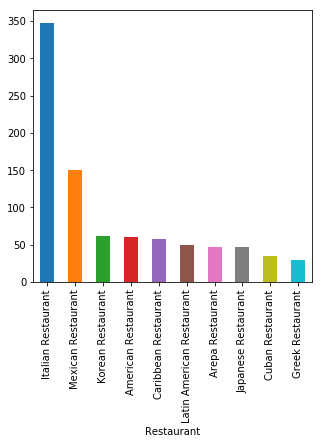

In [10]:
popular_Restaurant.plot(kind='bar',y='Count',x=popular_Restaurant['Restaurant'],figsize=(5,5),legend=False)
plt.show()

In [11]:
Bronx_res=len(Restaurant_all) # all restraunt in Bronx area
popular_Restaurant_percentage=[x/Bronx_res for x in popular_Restaurant['Count'] ]
popular_Restaurant_percentage.append(1-(sum(popular_Restaurant_percentage)))
popular_Restaurant_percentage[-1]
print('The top 10 restaurant categories account for', "{0:.0%}".format(1-popular_Restaurant_percentage[-1]),"of all restaurants" )
print("Other types of restaurant only account for","{0:.0%}".format(popular_Restaurant_percentage[-1]),"of all restaurants")

The top 10 restaurant categories account for 78% of all restaurants
Other types of restaurant only account for 22% of all restaurants


### Restaurant in each neigborhood

In [12]:
def Restaurant_count(neib,pop_rst):
    pop_rst_list=[]
    for i in range(len(neib)):
        if neib['Venue Category'][i] in list(pop_rst['Restaurant']):
            pop_rst_list.append(neib['Venue Category'][i])
    pop_rst_count=Counter(pop_rst_list) 
    out_put_list=[]
    for j in range(len(pop_rst)):
        if pop_rst_count.get(pop_rst['Restaurant'][j])!=None:
            out_put_list.append(pop_rst_count.get(pop_rst['Restaurant'][j]))
        else: 
            out_put_list.append(0)
    return(out_put_list)
def all_restaurant(neib):
    total_res_neib= len([a for a in neib['Venue Category'] if 'Restaurant'in a])
    return(total_res_neib)
    

###  Restaurant profile: the percentage of each type of Restaurant in each neighborhood

In [13]:
#df_aaa=Bronx_venues[Bronx_venues['Neighborhood']=='Belmont']
#Restaurant_count(df_aaa,popular_Restaurant)
#all_restaurant(df_aaa)

nei_res_matrix=pd.DataFrame()

for k in All_Neighborhood:
    df_nb=Bronx_venues[Bronx_venues['Neighborhood']==k].reset_index()  
    p_count=Restaurant_count(df_nb,popular_Restaurant)
    total_count=all_restaurant(df_nb)
    p_percentage= [x/total_count for x in p_count]
    nei_res_matrix[k]=p_percentage

# calculate percentage of other Restaurant
nei_res_matrix=nei_res_matrix.append(pd.Series(list(1-nei_res_matrix.sum()), index= nei_res_matrix.columns), ignore_index=True)
new_list=list(popular_Restaurant['Restaurant'])
new_list.append('other')
nei_res_matrix.index=new_list
nei_res_relative=nei_res_matrix.sub(popular_Restaurant_percentage, axis='rows')



In [14]:
#sns.heatmap(nei_res_relative.drop('other',axis=0), center=0) 

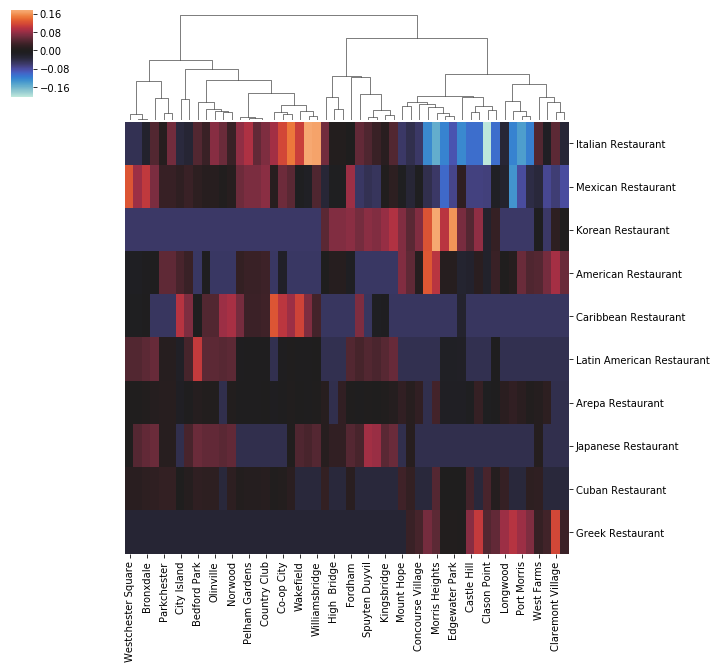

In [15]:
sns.clustermap(nei_res_relative.drop('other',axis=0,),metric='correlation',row_cluster=False, center=0)
plt.show()# comparing Restaurant percentag in each neighborhood to over all percentage , red indicate above average, blue indicate below average